In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from datetime import datetime
from datetime import timedelta
import pytz


In [5]:
df = pd.read_csv("manual_harvest_data.csv")
df = df.rename(columns={"Date":"date", "Tank ID":"tank_id", "Before Harvest (kg)":"before", "After Harvest (kg)":"after", "Removed (kg)":"removed", "Comments":"comments"})
df["datetime"] = pd.to_datetime(df.date)
df.head()

,date,tank_id,before,after,removed,comments,Unnamed: 6,Unnamed: 7,datetime
0,3.9.23,1,52.10,22.11,29.99,NaN,NaN,NaN,2023-03-09
1,3.9.23,2,0.00,0.00,0.00,Remained Empty,NaN,NaN,2023-03-09
2,3.9.23,3,51.81,0.00,51.81,Empty,NaN,NaN,2023-03-09
3,3.9.23,4,NaN,NaN,32.20,NaN,NaN,NaN,2023-03-09
4,3.9.23,5,NaN,NaN,22.70,NaN,NaN,NaN,2023-03-09


In [6]:
def get_algae_mass(start_date, end_date, tank):
    # only get data from specific tank
    sub_df = df[df.tank_id == tank].copy()
    # all days where the algae is reset
    restocks = np.array(sub_df[(sub_df.after > 0)].datetime, dtype='datetime64[s]')
    # all days where the algae is fully measured
    empties = np.array(sub_df[sub_df.before > 0].datetime, dtype='datetime64[s]')
    #generate an array for all recorded time
    days = (end_date - start_date).days
    date_range = [start_date + timedelta(hours=24*i) for i in range(days + 2)]
    algae_mass = np.zeros(len(date_range))

    #remove case where restock and empty are the same day
    if (restocks[-1] >= empties[-1]):
        restocks = restocks[:-1]

    rdx = len(restocks)

    # print(restocks, "\n", empties)

    for e in reversed(empties):
        rdx = rdx -1
        if rdx < 0:
            continue

        #get restock date for current empty date
        r = restocks[rdx]
        #get time between restock and empty date
        t = ( (e - r) / 60 / 60 / 24).astype('int') - 1
        #get starting mass
        start_mass = sub_df[sub_df.datetime == r].after.values[0]
        #get emptied mass
        end_mass = sub_df[sub_df.datetime == e].before.values[0]
        #get mass removed between restock and emptied dates
        removed_mass = sub_df[(sub_df.removed > 0) & (sub_df.datetime > r) & (sub_df.datetime < e)].removed.values.sum()
        #approximate mass growth per day
        mass_per_day = (end_mass + removed_mass - start_mass) / t

        start_idx = (r.astype(datetime) - start_date).days + 1
        end_idx = (e.astype(datetime) - start_date).days

        for i in range(start_idx, end_idx + 1):
            # print(date_range[i])
            #restock day
            if i == start_idx:
                algae_mass[i] = start_mass
            else:
                #add daily algae growth
                algae_mass[i] = algae_mass[i - 1] + mass_per_day
                #subtract algae if partial harvest day
                day_vals = sub_df[(date_range[i] - sub_df.datetime) == np.timedelta64(11, 'h')]
                removed = day_vals.removed.values
                if removed.any():
                    algae_mass[i] -= removed[0]

                # algae_mass[i] = round(algae_mass[i], 2)

    return algae_mass

    

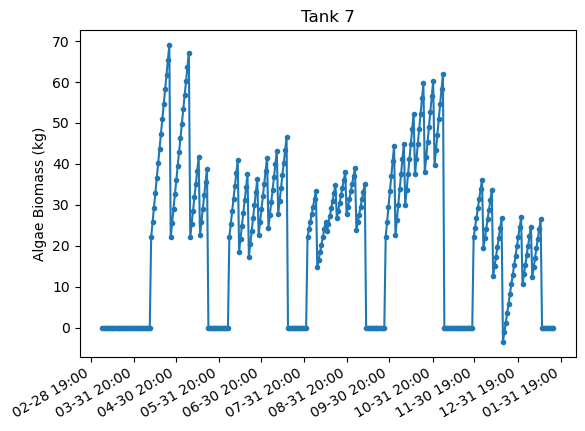

In [14]:
# Set date format for x-axis labels
date_fmt = '%m-%d %H:%M'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt, tz=(pytz.timezone("US/Eastern")))


start_date = datetime(2023, 3, 9, 11, 0)
end_date = datetime(2024, 1, 25, 11, 0)
days = (end_date - start_date).days
date_range = [start_date + timedelta(hours=24*i) for i in range(days + 2)]
tank = 7
algae_mass = get_algae_mass(start_date, end_date, tank)
delta_mass = algae_mass[1:] - algae_mass[:-1]
lower = datetime(2023, 5, 19, hour=23)
lower = pytz.timezone("US/Eastern").localize(start_date)
upper = datetime(2023, 7, 20, hour=23)
upper = pytz.timezone("US/Eastern").localize(end_date)

plt.figure()
plt.plot(date_range, algae_mass, marker='.')
# plt.plot(date_range[1:], delta_mass, marker='.')
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)

plt.ylabel("Algae Biomass (kg)")
plt.title("Tank " + str(tank))
# plt.xlim(lower, upper)
# plt.ylim(0, 8)
plt.show()

Create a new CSV with all data from all tanks

In [15]:
# date range
days = (end_date - start_date).days
date_range = [start_date + timedelta(hours=24*i) for i in range(days + 2)]

# create an empty data frame with right lenght
empty = np.zeros(len(date_range))

output_dict = {'date': date_range, 'tank1' : empty, 'tank2' : algae_mass, 'tank3' : empty, 'tank4' : empty, 'tank5' : empty,
               'tank6': empty, 'tank7': empty, 'tank8': empty}

output_df = pd.DataFrame(data=output_dict)

for tank in range(1, 9):
    tank_id = "tank" + str(tank)
    algae_mass = get_algae_mass(start_date, end_date, tank)
    output_df[tank_id] = algae_mass

output_df.head()

,date,tank1,tank2,tank3,tank4,tank5,tank6,tank7,tank8
0,2023-03-09 11:00:00,22.110000,0.0,0.0,0.0,0.0,22.110000,0.0,0.0
1,2023-03-10 11:00:00,26.047407,0.0,0.0,0.0,0.0,26.276667,0.0,0.0
2,2023-03-11 11:00:00,29.984815,0.0,0.0,0.0,0.0,30.443333,0.0,0.0
3,2023-03-12 11:00:00,33.922222,0.0,0.0,0.0,0.0,34.610000,0.0,0.0
4,2023-03-13 11:00:00,37.859630,0.0,0.0,0.0,0.0,38.776667,0.0,0.0


In [16]:
output_df.to_csv('harvest_data.csv')